In [1]:
import pandas as pd
import requests, json
from config import fred_api_key, quandl_api_key
import datetime as dt

In [2]:
# FRED access and criteria
realtime_start = "1960-01-01"
realtime_end = "9999-12-31"
series_id = "UMCSENT"
frequency= "q"
consumer_address = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&frequency={frequency}&api_key={fred_api_key}&file_type=json"

# Quandl access and criteria
exchange_code = "CME_HG1"
copper_address = f"https://www.quandl.com/api/v3/datasets/CHRIS/{exchange_code}?api_key={quandl_api_key}"

In [3]:
# FRED json
consumer_json = requests.get(consumer_address).json()

# Quandl json
copper_json = requests.get(copper_address).json()

In [4]:
# Quandl cleaning headers for dataframe
copper_headers = copper_json["dataset"]["column_names"]
clean_copper_headers = []
for header in copper_headers:
    header = header.lower().replace(" ", "_")
    clean_copper_headers.append(header)

In [5]:
# FRED data frame clean and create
consumer_df = pd.DataFrame(consumer_json["observations"])
consumer_df = consumer_df[consumer_df.value != '.']
consumer_df = consumer_df.reset_index()
consumer_df = consumer_df.drop(columns = ["index","realtime_end","realtime_start"], axis=1)

# Quandl data frame
copper_df = pd.DataFrame(copper_json["dataset"]["data"], columns = clean_copper_headers)


In [6]:
consumer_df.head()

,date,value
0,1953-01-01,90.7
1,1953-07-01,80.8
2,1953-10-01,80.7
3,1954-01-01,82.0
4,1954-04-01,82.9


In [7]:
#FRED integer and datetime changer

consumer_df['date'] = pd.to_datetime(consumer_df['date'])
consumer_df['value'] = pd.to_numeric(consumer_df['value'])

#for index, row in consumer_df.iterrows():
#    row.date = dt.date.fromisoformat(row.date)
#    row.value = float(row.value)



In [8]:
copper_df["date"]= pd.to_datetime(copper_df["date"])
# Quandl integer and datetime changer
#for index, row in copper_df.iterrows():
#    row.date = dt.date.fromisoformat(row.date)
#    mon = row.date.month
#    if mon >= 1 and mon <= 3:
#        mon = 1
#     elif mon >= 4 and mon <= 6:
#         mon = 4
#     elif mon >= 7 and mon <= 9:
#         mon = 7
#     elif mon >= 10 and mon <= 12:
#         mon = 10
#     copper_df.date[index] = row.date.replace(month = mon , day = 1)

In [9]:
copper_df.tail(50)

,date,open,high,low,last,change,settle,volume,previous_day_open_interest
14866,1959-09-10,0.3122,0.3130,0.3110,0.3122,NaN,0.3122,59.0,1015.0
14867,1959-09-09,0.3137,0.3155,0.3134,0.3137,NaN,0.3137,85.0,1036.0
14868,1959-09-08,0.3163,0.3183,0.3150,0.3163,NaN,0.3163,62.0,1030.0
14869,1959-09-04,0.3157,0.3159,0.3133,0.3157,NaN,0.3157,43.0,1029.0
14870,1959-09-03,0.3130,0.3140,0.3110,0.3130,NaN,0.3130,58.0,1034.0
14871,1959-09-02,0.3127,0.3155,0.3110,0.3127,NaN,0.3127,74.0,1037.0
14872,1959-09-01,0.3142,0.3182,0.3120,0.3142,NaN,0.3142,138.0,1053.0
14873,1959-08-31,0.3173,0.3175,0.3135,0.3173,NaN,0.3173,120.0,1028.0
14874,1959-08-28,0.3117,0.3117,0.3094,0.3117,NaN,0.3117,111.0,1021.0
14875,1959-08-27,0.3066,0.3075,0.3022,0.3066,NaN,0.3066,153.0,953.0


In [10]:
consumer_df.dtypes

date     datetime64[ns]
value           float64
dtype: object

In [11]:
consumer_df.plot(x="date",y="value", kind="line", figsize=(30,10))

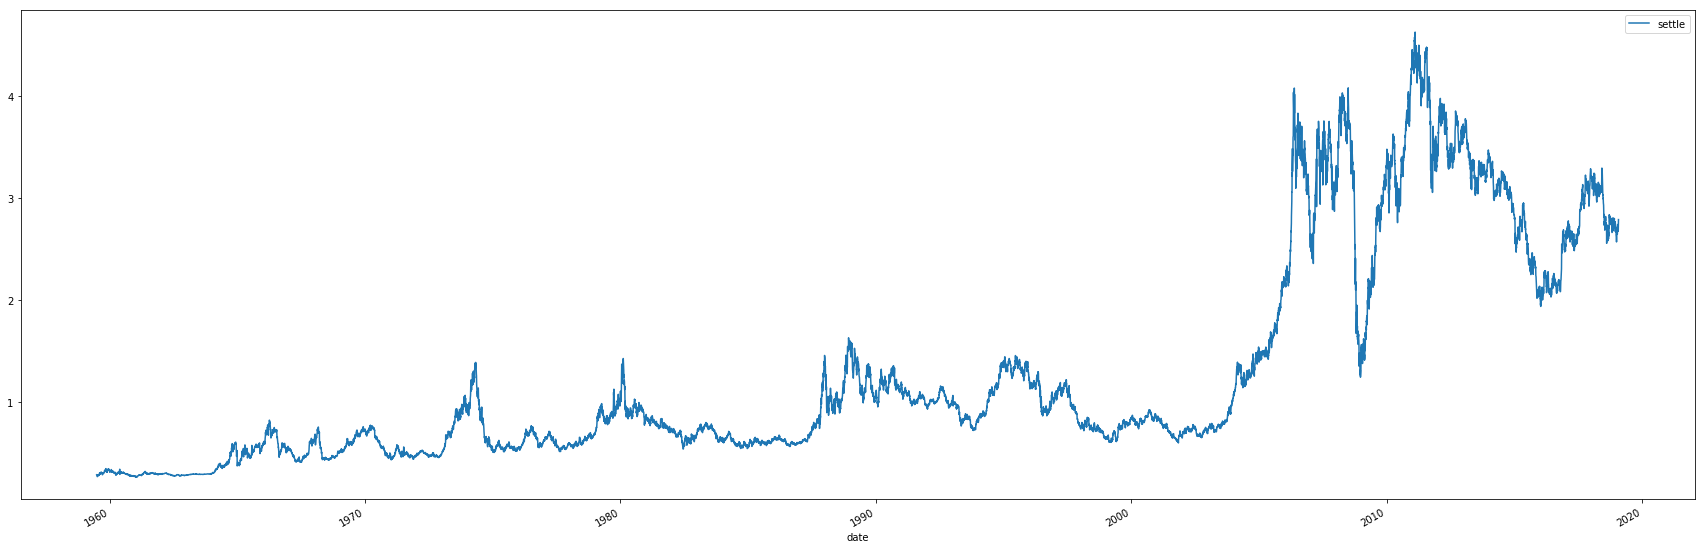

In [12]:
copper_chart = copper_df.plot(x="date", y="settle", kind="line", figsize=(30,10))


In [13]:
#FRED request discount rate

realtime_start = "1960-01-01"
realtime_end = "9999-12-31"
series_id = "INTDSRUSM193N"
frequency= "q"
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&frequency={frequency}&api_key={fred_api_key}&file_type=json"
discount_json = requests.get(url).json()

In [14]:
discount_rate = pd.DataFrame(discount_json["observations"])

In [15]:
discount_rate=discount_rate.loc[discount_rate["value"] != "."]

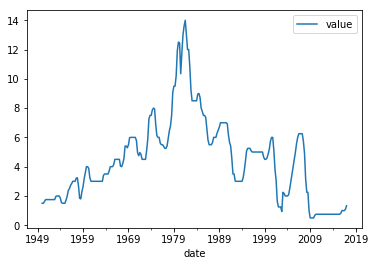

In [16]:
discount_rate['date'] = pd.to_datetime(discount_rate['date'])
discount_rate['value'] = pd.to_numeric(discount_rate['value'])
discount_rate = discount_rate.drop(['realtime_end', 'realtime_start'], axis=1)
discount_rate.plot(x="date", y="value", kind="line")

In [17]:
series_id = "GDPC1"
GDP_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=GDPC1&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()
GDP_df = pd.DataFrame(GDP_json["observations"])

In [18]:
GDP_df=GDP_df.loc[GDP_df["value"] != "."]
GDP_df.head()

,date,realtime_end,realtime_start,value
0,1947-01-01,2019-01-31,2019-01-31,2033.061
1,1947-04-01,2019-01-31,2019-01-31,2027.639
2,1947-07-01,2019-01-31,2019-01-31,2023.452
3,1947-10-01,2019-01-31,2019-01-31,2055.103
4,1948-01-01,2019-01-31,2019-01-31,2086.017


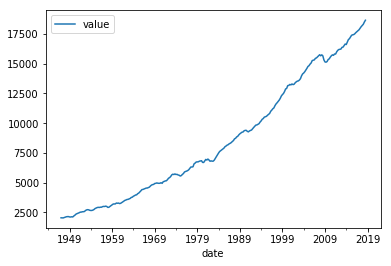

In [19]:
GDP_df['date'] = pd.to_datetime(GDP_df['date'])
GDP_df['value'] = pd.to_numeric(GDP_df['value'])
GDP_df = GDP_df.drop(['realtime_end', 'realtime_start'], axis=1)
GDP_df.plot(x="date", y="value", kind="line")

In [20]:
tenYearBond_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=GS10&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()


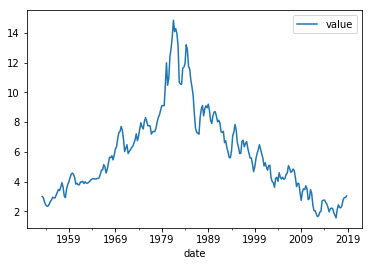

In [21]:
tenYearBondDF = pd.DataFrame(tenYearBond_json['observations'])
tenYearBondDF = tenYearBondDF.loc[tenYearBondDF['value'] != "."]
tenYearBondDF['date'] = pd.to_datetime(tenYearBondDF['date'])
tenYearBondDF['value'] = pd.to_numeric(tenYearBondDF['value'])
tenYearBondDF = tenYearBondDF.drop(['realtime_end', 'realtime_start'], axis=1)
tenYearBondDF.plot(x="date", y="value", kind="line")

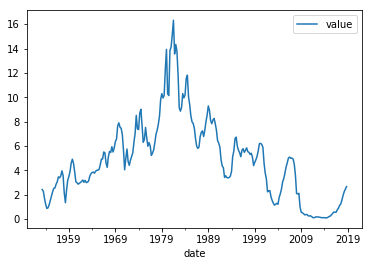

In [22]:
oneYearBond_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=GS1&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()
oneYearBondDF = pd.DataFrame(oneYearBond_json['observations'])
oneYearBondDF = oneYearBondDF.loc[oneYearBondDF['value'] != "."]
oneYearBondDF['date'] = pd.to_datetime(oneYearBondDF['date'])
oneYearBondDF['value'] = pd.to_numeric(oneYearBondDF['value'])

oneYearBondDF.plot(x="date", y="value", kind="line")

In [23]:
oneYearBondDF = oneYearBondDF.drop(['realtime_end', 'realtime_start'], axis=1)
oneYearBondDF.head()

,date,value
0,1953-04-01,2.43
1,1953-07-01,2.29
2,1953-10-01,1.71
3,1954-01-01,1.23
4,1954-04-01,0.88


        date  value
0 1948-01-01    3.7
1 1948-04-01    3.7
2 1948-07-01    3.8
3 1948-10-01    3.8
4 1949-01-01    4.7


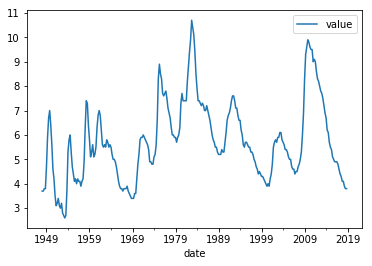

In [24]:
unemployment_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=UNRATE&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()
unemployment= pd.DataFrame(unemployment_json['observations'])
unemployment = unemployment.loc[unemployment['value'] != "."]
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment['value'] = pd.to_numeric(unemployment['value'])
unemployment = unemployment.drop(['realtime_end', 'realtime_start'], axis=1)
unemployment.plot(x="date", y="value", kind="line")
print(unemployment.head())

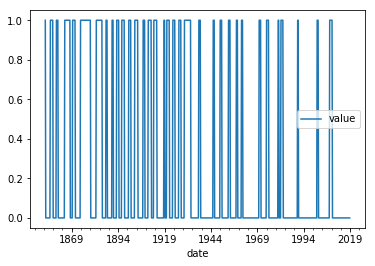

In [25]:
#recession_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=JHDUSRGDPBR&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()
recession_json = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id=USRECQ&frequency={frequency}&api_key={fred_api_key}&file_type=json").json()
recession= pd.DataFrame(recession_json['observations'])
recession = recession.loc[recession['value'] != "."]
recession['date'] = pd.to_datetime(recession['date'])
recession['value'] = pd.to_numeric(recession['value'])
recession=recession.drop(['realtime_end', 'realtime_start'], axis=1)
recession.plot(x="date", y="value", kind="line")

In [26]:
recession.head()

,date,value
0,1854-10-01,1
1,1855-01-01,0
2,1855-04-01,0
3,1855-07-01,0
4,1855-10-01,0


In [27]:
merged_df=recession.merge(unemployment, on='date', how="outer")

In [28]:
merged_df=merged_df.merge(oneYearBondDF, on="date", how = "outer")
merged_df = merged_df.merge(tenYearBondDF, on="date", how = "outer")
merged_df = merged_df.merge(GDP_df, on="date", how="outer")
merged_df = merged_df.merge(discount_rate, on="date", how="outer")
merged_df.head()

,date,value_x,value_y,value_x,value_y,value_x,value_y
0,1854-10-01,1,NaN,NaN,NaN,NaN,NaN
1,1855-01-01,0,NaN,NaN,NaN,NaN,NaN
2,1855-04-01,0,NaN,NaN,NaN,NaN,NaN
3,1855-07-01,0,NaN,NaN,NaN,NaN,NaN
4,1855-10-01,0,NaN,NaN,NaN,NaN,NaN


In [29]:
merged_df.columns = ["Date", "Contraction", "Unemployment", "One Year Bond", "Ten Year Bond", "GDP", "Discount Rate"]

In [30]:
#add recession number for 1960
merged_df.loc[(merged_df["Date"] < dt.datetime(1961, 1, 1)) & (merged_df["Date"] > dt.datetime(1960, 1, 1)), "Contraction"] = 1.0

In [31]:
merged_df["Yield Spread"] = merged_df["Ten Year Bond"] - merged_df["One Year Bond"]

In [32]:
merged_df.head()

,Date,Contraction,Unemployment,One Year Bond,Ten Year Bond,GDP,Discount Rate,Yield Spread
0,1854-10-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1855-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1855-04-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1855-07-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1855-10-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
merged_df.loc[(merged_df["Date"] >= dt.datetime(1961, 1, 1)) & (merged_df["Date"] < dt.datetime(1967, 10, 1)), "Contraction"] = 0.0

In [34]:
merged_df = merged_df.sort_values(by=['Date'])
merged_df["GDP pct change"] = merged_df['GDP'].pct_change()
merged_df["GDP pct change"] = merged_df["GDP pct change"] * 100

In [35]:
merged_df = merged_df.dropna(axis = 0, how='any')

In [36]:
merged_df

,Date,Contraction,Unemployment,One Year Bond,Ten Year Bond,GDP,Discount Rate,Yield Spread,GDP pct change
394,1953-04-01,0.0,2.6,2.43,3.00,2718.709,2.00,0.57,0.772984
395,1953-07-01,1.0,2.7,2.29,2.92,2703.411,2.00,0.63,-0.562694
396,1953-10-01,1.0,3.7,1.71,2.64,2662.482,2.00,0.93,-1.513976
397,1954-01-01,1.0,5.3,1.23,2.44,2649.755,1.85,1.21,-0.478013
398,1954-04-01,1.0,5.8,0.88,2.35,2652.643,1.54,1.47,0.108991
399,1954-07-01,0.0,6.0,0.92,2.35,2682.601,1.50,1.43,1.129364
400,1954-10-01,0.0,5.3,1.17,2.47,2735.091,1.50,1.30,1.956683
401,1955-01-01,0.0,4.7,1.52,2.65,2813.212,1.50,1.13,2.856249
402,1955-04-01,0.0,4.4,1.85,2.76,2858.988,1.71,0.91,1.627179
403,1955-07-01,0.0,4.1,2.25,2.95,2897.598,1.97,0.70,1.350478


In [38]:
merged_df = merged_df.drop(["One Year Bond", "Ten Year Bond", "GDP", "Discount Rate"], axis = 1)

In [39]:
merged_df.head()

,Date,Contraction,Unemployment,Yield Spread,GDP pct change
394,1953-04-01,0.0,2.6,0.57,0.772984
395,1953-07-01,1.0,2.7,0.63,-0.562694
396,1953-10-01,1.0,3.7,0.93,-1.513976
397,1954-01-01,1.0,5.3,1.21,-0.478013
398,1954-04-01,1.0,5.8,1.47,0.108991


In [41]:
merged_df.to_csv("EconomicIndicators.csv", index = False)